# Examining Passenger Destinations From 2006 - 2016 Using Buraeu of Trasportation Statistics

## By Cain Soltoff

In [1]:
# Learning to use pandas by playing around with the flight data from the Bureau of Transportation Statistics

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [3]:
#read in the data from 2012-2018
d = []
for i in range(2012, 2018):
    d.append(pd.read_csv("FlightData/" + str(i) + ".csv"))
    
flightData = pd.concat(d, ignore_index=True)
                       
#just pull out the columns we want to use
cleanedFlightData = flightData.loc[:, ["DEST_CITY_NAME", "ORIGIN_CITY_NAME", "PASSENGERS", "MONTH", "QUARTER", "YEAR"]]

In [4]:
# Let's add some columns...

#Add a DATE column that combines the Year and Month Columns
cleanedFlightData["DATE"] = cleanedFlightData.apply(lambda row: datetime.datetime(row['YEAR'], row['MONTH'], 1), axis=1)


#Add a Destination and Origin State Column
cleanedFlightData["DEST_STATE"] = cleanedFlightData['DEST_CITY_NAME'].apply(lambda x: x[-2:])
cleanedFlightData["ORIGIN_STATE"] = cleanedFlightData['ORIGIN_CITY_NAME'].apply(lambda x: x[-2:])

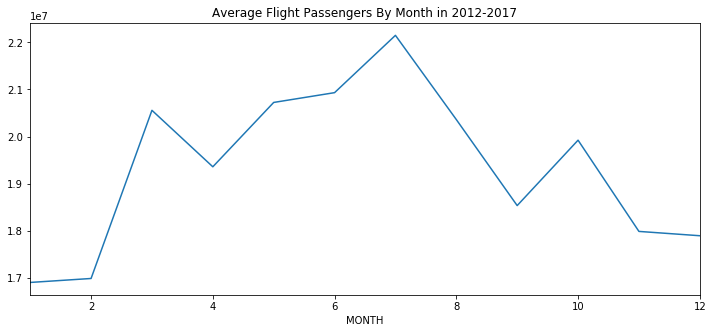

In [5]:
# Let's now aggregate each route by the mean travelers monthly travelers over the five year period

cleanedFightDataAveraged = cleanedFlightData.pivot_table("PASSENGERS", index=["DEST_CITY_NAME", "ORIGIN_CITY_NAME"], columns="MONTH").dropna().stack().reset_index()

cleanedFightDataAveraged.columns = ["DEST_CITY_NAME", "ORIGIN_CITY_NAME", "MONTH", "AVG_PASSENGERS"]

totalTravel = cleanedFightDataAveraged.groupby('MONTH')['AVG_PASSENGERS'].sum()
plt.figure(figsize=(12,5))
totalTravel.T.plot(title="Average Flight Passengers By Month in 2012-2017")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13a6b8048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x121fc2518>], dtype=object)

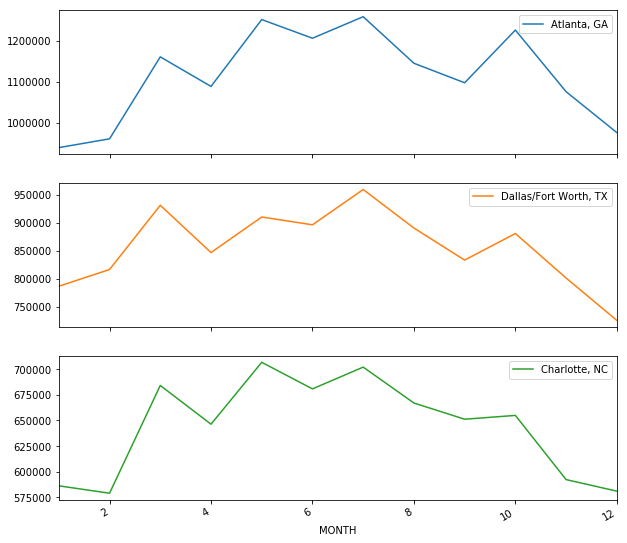

In [6]:
# Let's create a pivot table by destination city name and plot the top 3 travel destinations by total inbound travelers

monthlyTravelByDestination = cleanedFightDataAveraged.pivot_table(values='AVG_PASSENGERS', index='DEST_CITY_NAME', columns='MONTH', aggfunc=sum)

totalTravelByDestination = monthlyTravelByDestination.apply(sum, axis=1)

top3 = totalTravelByDestination.sort_values(ascending=False)[:3] #calculate the top 3 locations by total travelers

monthlyTravelByDestination.loc[top3.index].T.plot(subplots=True, figsize=(10,10)) #plot those

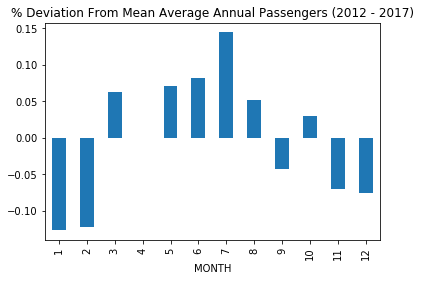

In [15]:
# Let's figure out which destination cities have travel patters that differ most from the national average

# Let's first express the national travel monthly pattern as a percent deviation of the monthly mean from the national annual mean
totalTravel = cleanedFightDataAveraged.groupby('MONTH')['AVG_PASSENGERS'].sum()
monthlyMeanPctDeviation = (totalTravel - totalTravel.mean())/totalTravel.mean()

# Let's plot it just to see
monthlyMeanPctDeviation.plot(kind='bar', title="% Deviation From Mean Average Annual Passengers (2012 - 2017)")

In [16]:
# let's create to helper functions

# the first will take a row and return a Series that is it's own % deviation from its mean

def meanPctDeviation(row):
    return (row - row.mean())/row.mean()

# the second will take a row's % deviation from it's own mean and calcualte the sum of squared error relative to the national average
def calcDeviationFromTotalMean(row):
    return ((row - monthlyMeanPctDeviation.T) ** 2)

In [17]:
#since the data for smaller cities may be erractic, let's take out any cities that don't get 250,000 travelers per year
monthlyTravelByDestinationOverLimit = monthlyTravelByDestination.loc[monthlyTravelByDestination.sum(axis=1) > 250000]
monthlyTravelByDestinationDeviations = monthlyTravelByDestinationOverLimit.apply(meanPctDeviation, axis=1).dropna()
monthlyTravelByDestinationDeviationFromNational = monthlyTravelByDestinationDeviations.apply(calcDeviationFromTotalMean, axis=1).sum(axis=1)

In [ ]:
#get the top outliers and plot them
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

destinationOutliers = monthlyTravelByDestinationDeviationFromNational.sort_values(ascending=False)
#plot them 
p = monthlyTravelByDestination.loc[destinationOutliers.index[:5]].T.plot(subplots=True, figsize=(15,10), sharex=True)
p[-1].set_xticks(range(1, 13))
p[-1].set_xticklabels(months, rotation=90)

In [ ]:
#what travel destinations have the most consistent travelers?
mostStable = monthlyTravelByDestinationDeviations.std(axis=1).sort_values(ascending=True)
p = monthlyTravelByDestination.loc[mostStable.index[:5]].T.plot(subplots=True, figsize=(15,10), sharex=True)
p[-1].set_xticks(range(1, 13))
p[-1].set_xticklabels(months, rotation=90)